In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import sys
from importlib import reload
from pathlib import Path
import scanpy as sc
from pylab import rcParams
from matplotlib.patches import Patch
import re
import seaborn as sns
import glob

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import scvelo as scv
scv.logging.print_version()


scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.set_figure_params('scvelo')  # for beautified visualization

%matplotlib inline

Running scvelo 0.2.2 (python 3.8.3) on 2020-10-19 10:51.


In [2]:
def adata_louvain_name_convert(inputAdata, orderDf, louvainNewOrdered, louvainOldOrdered):
    inputAdata.obs["louvain_celltype"] = ["%s_%s"%(x,y) for index, (x,y) in enumerate(zip(inputAdata.obs['louvain'], inputAdata.obs['cell_type']))]
    inputAdata.obs["celltype_general"] = [x[0] for x in inputAdata.obs['cell_type']]
    
    #--- Match old & new louvain levels
    inputAdata.obs['louvain_old'] = inputAdata.obs['louvain']
    inputAdata.uns['louvain_old_colors'] = inputAdata.uns['louvain_colors']
    inputAdata.obs['louvain'] = [ louvainNewOrdered[louvainOldOrdered.index(int(x))] for x in inputAdata.obs['louvain'] ]
    category_order = orderDf.sort_values('louvain')['louvain_new_label'].tolist()
    category_order = [x for x in category_order if x in np.unique(inputAdata.obs['louvain'])]
    inputAdata.obs['louvain'] = pd.Categorical(inputAdata.obs['louvain'].tolist(), categories=category_order) # The key is to set categories according to original order...

    inputAdata.obs['Infection type'] = [ 'Armstrong' if 'A' in x else 'Clone13' if 'C' in x else 'Naive' for x in inputAdata.obs['cell_type']]
    inputAdata.obs['cell_id'] = inputAdata.obs.index.tolist()

In [3]:
###----- Get dir & load / reload packages
try:
    code_dir
except NameError:
    print("Start")
    code_dir = os.getcwd()
    base_dir = code_dir.replace("/plotting_codes","")
    tools_dir = base_dir + "/tools"

    sys.path.insert(1, tools_dir)
    import sc_addons
    import sc_pl_addons
else:
    print("Reload")
    reload(sc_addons)
    reload(sc_pl_addons)

Start


In [4]:
## ----- Setup working dir
sp_name = "0_Acute-Chronic"
analysis_name = ["0", "resampled"] 

wk_dir = base_dir + "/9_Figures/%s/%s_%s/scVelo"%(sp_name, analysis_name[0], analysis_name[1])
Path(wk_dir).mkdir(parents=True, exist_ok=True)
os.chdir(wk_dir)

print(sp_name)

0_Acute-Chronic


In [5]:
###----- old - new cluster names
order_file ='%s/%s/2_scVelo'%(base_dir, sp_name) + '/%s_scVelo_out_%sNoDyn/pt_ordered_cluster_avg.csv'%(analysis_name[0], analysis_name[1])
order_df = pd.read_csv(order_file)
louvain_new_ordered = order_df['louvain_new_label'].tolist()
louvain_old_ordered = order_df['louvain'].tolist()

In [6]:
resampled_h5ad = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/2_scVelo/0_scVelo_out_resampled/0_Acute-Chronic_scVelo_postPT.h5ad'
adata = scv.read(resampled_h5ad)

adata_louvain_name_convert(adata, order_df, louvain_new_ordered, louvain_old_ordered)

In [7]:
paga_xmax, paga_ymax = np.amax(adata.obsm['paga'], axis=0)
paga_xmin, paga_ymin = np.amin(adata.obsm['paga'], axis=0)
paga_dx, paga_dy = paga_xmax - paga_xmin, paga_ymax - paga_ymin
paga_xmax, paga_xmin = paga_xmax + paga_dx*0.1, paga_xmin - paga_dx*0.1
paga_ymax, paga_ymin = paga_ymax + paga_dy*0.1, paga_ymin - paga_dy*0.1

In [15]:
### Intersect chromatin regulators & TF & cell surface receptors
surface_df = pd.read_csv('https://raw.githubusercontent.com/Yolanda-HT/SurfaceMarkerSelect/master/MM_MARKERS.csv')
surface_genes = surface_df['gene_name'].tolist()
crf_df = pd.read_csv('https://raw.githubusercontent.com/ScrippsPipkinLab/CRF_Screen/master/Ref/CRF_all.csv?token=AGIX2OZNRQF2KWG2ZLZ6ZDC7S35MU')
crf_genes = crf_df['gene_name'].tolist() + [x for x in crf_df['Alternative'].tolist() if str(x) != 'nan']
tf_df = pd.read_csv('https://raw.githubusercontent.com/Yolanda-HT/TFclassDataCollection/master/Ravasi_TF.csv')
tf_genes = tf_df['symbol'].tolist()
all_genes = list(set(surface_genes + crf_genes + tf_genes))

### Gene signature genes
gs_plot_use_file = '/media/pipkin/ROCKET-PRO/T_cell_signature_Reference/Y_annotated/anno_plotuse_gs_20200928.csv'
gs_plot_use_df = pd.read_csv(gs_plot_use_file)
gs_use = gs_plot_use_df[gs_plot_use_df['plot_use'].notnull()]['gs_name'].tolist()

gs_file = '/media/pipkin/ROCKET-PRO/T_cell_signature_Reference/X_GeneSignatures_mm/all_mouse_T_cell_signatures.csv'
gs_df = pd.read_csv(gs_file)
gs_df_use = gs_df[[True if x in gs_use else False for x in gs_df['gs_name']]]
genes_use = list(set(gs_df_use['gene_symbol'].tolist()))

genes_use = [i for i in genes_use if i in all_genes]

In [90]:
out_dir = wk_dir + '/likelihood_genes'
Path(out_dir).mkdir(parents=True, exist_ok=True)

## Extract likelihood genes for all activated cells ARM v.s. CL13

In [154]:
# Armstrong
adata_ij_file = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/2_scVelo/2_scVelo_out_actARMonly/0_Acute-Chronic_scVelo_postPT.h5ad'
adata_ij = scv.read(adata_ij_file)
top_genes = adata_ij.var['fit_likelihood'].sort_values(ascending=False)
top_genes = top_genes[top_genes > 0]
top_genes = top_genes[[True if x in genes_use else False for x in top_genes.index]]

arm_top_genes = top_genes.index.tolist()
arm_top_genes_score = top_genes.tolist()

# Cl13
adata_ij_file = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/2_scVelo/3_scVelo_out_actCL13only/0_Acute-Chronic_scVelo_postPT.h5ad'
adata_ij = scv.read(adata_ij_file)
top_genes = adata_ij.var['fit_likelihood'].sort_values(ascending=False)
top_genes = top_genes[top_genes > 0]
top_genes = top_genes[[True if x in genes_use else False for x in top_genes.index]]

cl13_top_genes = top_genes.index.tolist()
cl13_top_genes_score = top_genes.tolist()

# All
adata_ij_file = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/2_scVelo/1_scVelo_out_ACTonly/0_Acute-Chronic_scVelo_postPT.h5ad'
adata_ij = scv.read(adata_ij_file)
top_genes = adata_ij.var['fit_likelihood'].sort_values(ascending=False)
top_genes = top_genes[top_genes > 0]
top_genes = top_genes[[True if x in genes_use else False for x in top_genes.index]]

all_top_genes = top_genes.index.tolist()
all_top_genes_score = top_genes.tolist()

#Create output df
out_df = pd.DataFrame()

out_df['All_ranked'] = pd.Series(all_top_genes)
out_df['All_ranked_likelihood'] = pd.Series(all_top_genes_score)
out_df['Arm_ranked'] = pd.Series(arm_top_genes)
out_df['Arm_ranked_likelihood'] = pd.Series(arm_top_genes_score)
out_df['Cl13_ranked'] = pd.Series(cl13_top_genes)
out_df['Cl13_ranked_likelihood'] = pd.Series(cl13_top_genes_score)

arm_uniq = list(set(arm_top_genes) - (set(cl13_top_genes) & set(arm_top_genes)))
cl13_uniq = list(set(cl13_top_genes) - (set(cl13_top_genes) & set(arm_top_genes)))
common = list(set(cl13_top_genes) & set(arm_top_genes))

out_df['Arm_unique'] = pd.Series(arm_uniq)
out_df['Cl13_unique'] = pd.Series(cl13_uniq)
out_df['Arm-Cl13_common'] = pd.Series(common)
out_df.to_csv("likelihood_genes/act_Arm-Cl13_likelihood_genes.csv", index=False)

## Extract likelihood genes for pairwise clusters

In [152]:
cluster_vs_cluster_scvelo_dir = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/2_scVelo/4_scVelo_out_LouvainCluster'

In [ ]:
cp_use = [ ["P2", "P5"], ["P5","P6"], ["P5","P3"],
           ["P2", "P7"], ["P7","P8"],
           ["P2", "P4"], ["P4","P9"], ["P9","P10"] ]

for cp_ij in cp_use:
    cp_ij_old = [louvain_old_ordered[louvain_new_ordered.index(x)] for x in cp_ij]
    if cp_ij_old[1] < cp_ij_old[0]:
        cp_ij_old = [cp_ij_old[1], cp_ij_old[0]]
        cp_ij = [cp_ij[1], cp_ij[0]]
    
    # Armstrong
    use_type = "ARM"
    adata_ij_file = cluster_vs_cluster_scvelo_dir + "/%s-louvain--%s_%s_scVelo.h5ad"%(use_type,cp_ij_old[0], cp_ij_old[1])
    if os.path.exists(adata_ij_file):
        adata_ij = scv.read(adata_ij_file)
        top_genes = adata_ij.var['fit_likelihood'].sort_values(ascending=False)
        top_genes = top_genes[top_genes > 0]
        top_genes = top_genes[[True if x in genes_use else False for x in top_genes.index]]

        arm_top_genes = top_genes.index.tolist()
        arm_top_genes_score = top_genes.tolist()
    else:
        arm_top_genes = []
        arm_top_genes_score = []
    
    # Cl13
    use_type = "CL13"
    adata_ij_file = cluster_vs_cluster_scvelo_dir + "/%s-louvain--%s_%s_scVelo.h5ad"%(use_type,cp_ij_old[0], cp_ij_old[1])
    if os.path.exists(adata_ij_file):
        adata_ij = scv.read(adata_ij_file)
        top_genes = adata_ij.var['fit_likelihood'].sort_values(ascending=False)
        top_genes = top_genes[top_genes > 0]
        top_genes = top_genes[[True if x in genes_use else False for x in top_genes.index]]

        cl13_top_genes = top_genes.index.tolist()
        cl13_top_genes_score = top_genes.tolist()
    else:
        cl13_top_genes = []
        cl13_top_genes_score = []
    
    # All
    adata_ij_file = cluster_vs_cluster_scvelo_dir + "/louvain--%s_%s_scVelo.h5ad"%(cp_ij_old[0], cp_ij_old[1])
    adata_ij = scv.read(adata_ij_file)
    top_genes = adata_ij.var['fit_likelihood'].sort_values(ascending=False)
    top_genes = top_genes[top_genes > 0]
    top_genes = top_genes[[True if x in genes_use else False for x in top_genes.index]]

    all_top_genes = top_genes.index.tolist()
    all_top_genes_score = top_genes.tolist()
    
    #Create output df
    out_df = pd.DataFrame()

    out_df['All_ranked'] = pd.Series(all_top_genes)
    out_df['All_ranked_likelihood'] = pd.Series(all_top_genes_score)
    out_df['Arm_ranked'] = pd.Series(arm_top_genes)
    out_df['Arm_ranked_likelihood'] = pd.Series(arm_top_genes_score)
    out_df['Cl13_ranked'] = pd.Series(cl13_top_genes)
    out_df['Cl13_ranked_likelihood'] = pd.Series(cl13_top_genes_score)

    arm_uniq = list(set(arm_top_genes) - (set(cl13_top_genes) & set(arm_top_genes)))
    cl13_uniq = list(set(cl13_top_genes) - (set(cl13_top_genes) & set(arm_top_genes)))
    common = list(set(cl13_top_genes) & set(arm_top_genes))

    out_df['Arm_unique'] = pd.Series(arm_uniq)
    out_df['Cl13_unique'] = pd.Series(cl13_uniq)
    out_df['Arm-Cl13_common'] = pd.Series(common)
    out_df.to_csv("likelihood_genes/%s-%s_Arm-Cl13_likelihood_genes.csv"%(cp_ij[0], cp_ij[1]), index=False)

## P2 signature & driver gene

In [233]:
driver_gene_dir = base_dir + '/9_Figures/0_Acute-Chronic/0_resampled/scVelo/likelihood_genes'
dg_files = glob.glob("%s/*.csv"%driver_gene_dir)

p2_dg_files = [x  for x in dg_files if "P2" in x]

all_drivers_file = base_dir + '/9_Figures/0_Acute-Chronic/0_resampled/scVelo/likelihood_genes/act_Arm-Cl13_likelihood_genes.csv'
all_drivers_df = pd.read_csv(all_drivers_file)
all_drivers  = all_drivers_df[all_drivers_df['All_ranked_likelihood'] > 0.25]['All_ranked'].tolist()

for i in p2_dg_files:
    i_drivers_df = pd.read_csv(i)
    i_drivers  = i_drivers_df[i_drivers_df['All_ranked_likelihood'] > 0.25]['All_ranked'].tolist()
    all_drivers = list(set(all_drivers) & set(i_drivers))

In [248]:
###----- Read signature gene spreadsheet & intersect signature and driver genes
sig_genes_file = base_dir + '/9_Figures/0_Acute-Chronic/0_resampled/louvain_signature_genes_neworder.csv'
sig_genes_df = pd.read_csv(sig_genes_file)

p2_sig_genes = sig_genes_df['P2'].tolist()
p2_sig_driver_genes = list(set(p2_sig_genes) & set(all_drivers))

p2_sig_driver_genes_likelihood = all_drivers_df[['All_ranked', 'All_ranked_likelihood']].set_index('All_ranked').loc[p2_sig_driver_genes]
p2_sig_driver_genes_likelihood

,All_ranked_likelihood
All_ranked,
Uhrf1,0.460402
Mcm4,0.574333
Tfdp1,0.404338
Parp1,0.296431
Il2ra,0.254789
Snrpd1,0.460387
Trip13,0.357444
Hells,0.520500
Wdhd1,0.339723


In [250]:
p2_sig_driver_genes

['Uhrf1',
 'Mcm4',
 'Tfdp1',
 'Parp1',
 'Il2ra',
 'Snrpd1',
 'Trip13',
 'Hells',
 'Wdhd1',
 'Timeless',
 'E2f8']

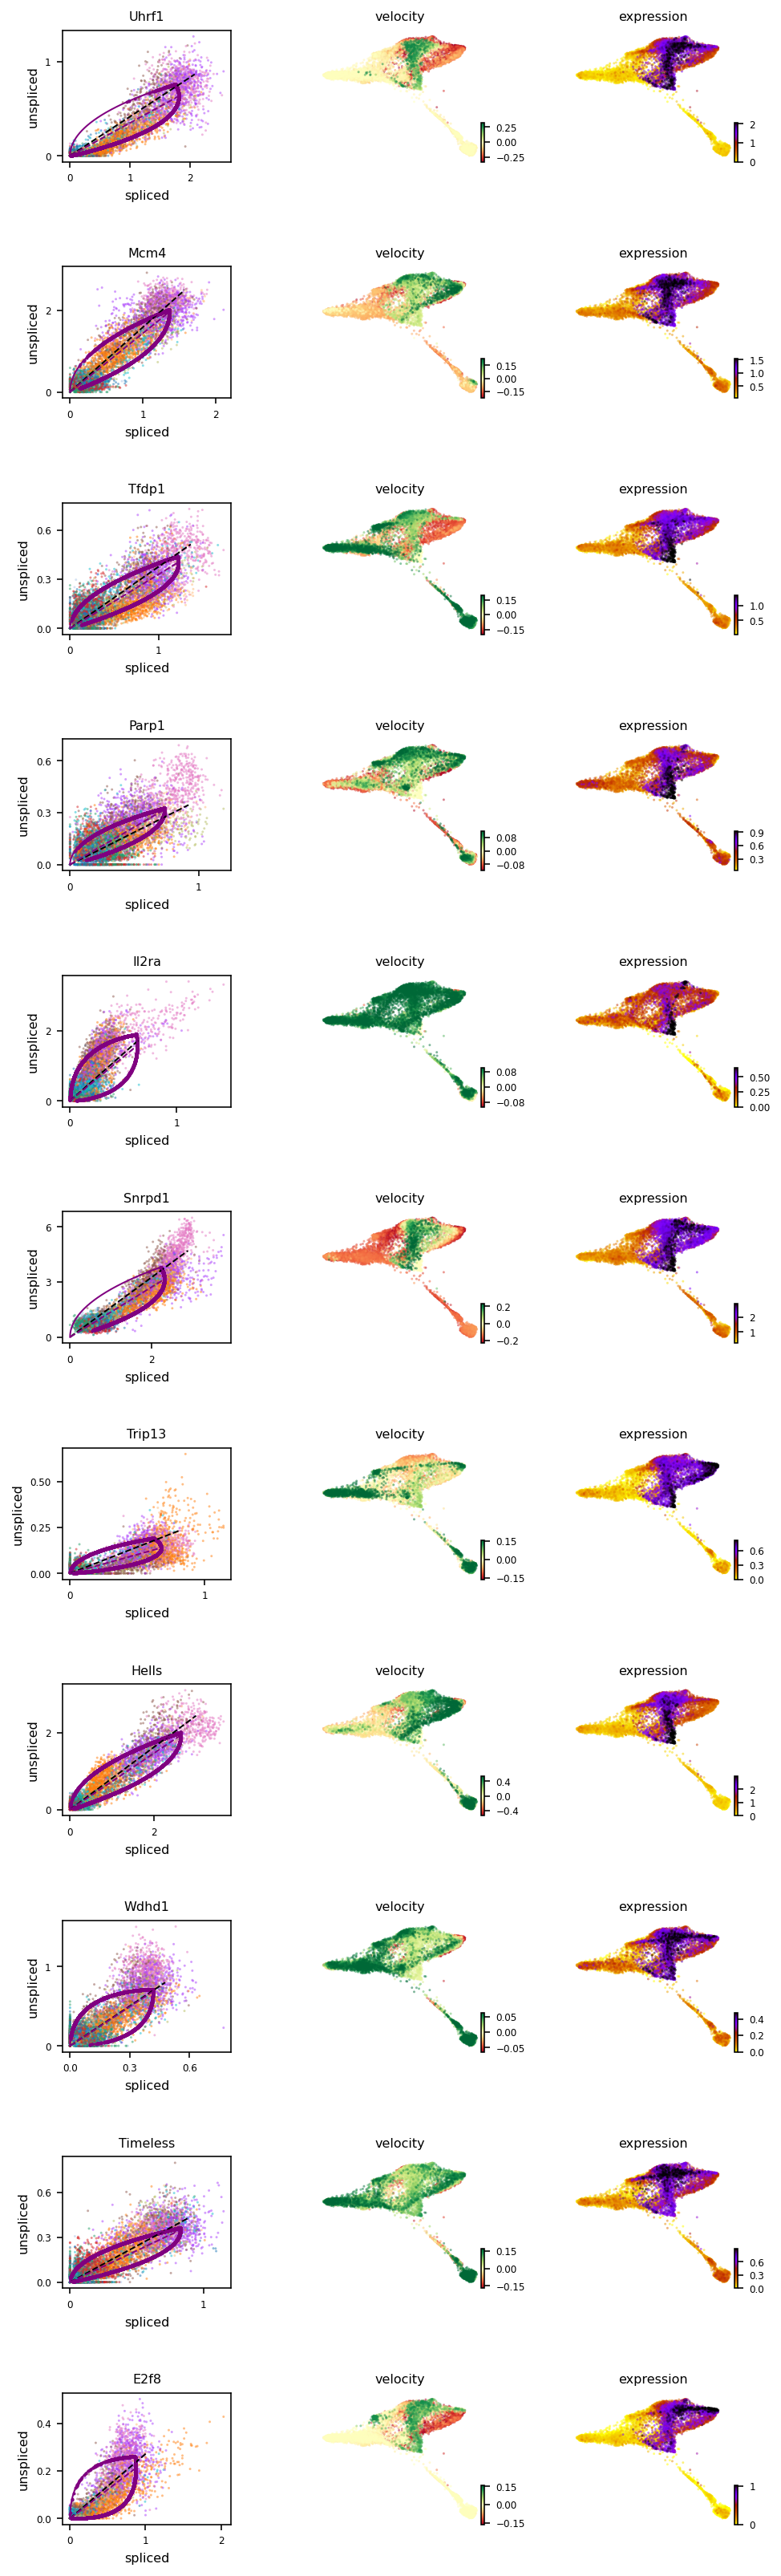

In [249]:
rcParams['figure.figsize'] = 5,5
scv.pl.velocity(adata, p2_sig_driver_genes, basis='paga')